In [ ]:
# General libraries
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


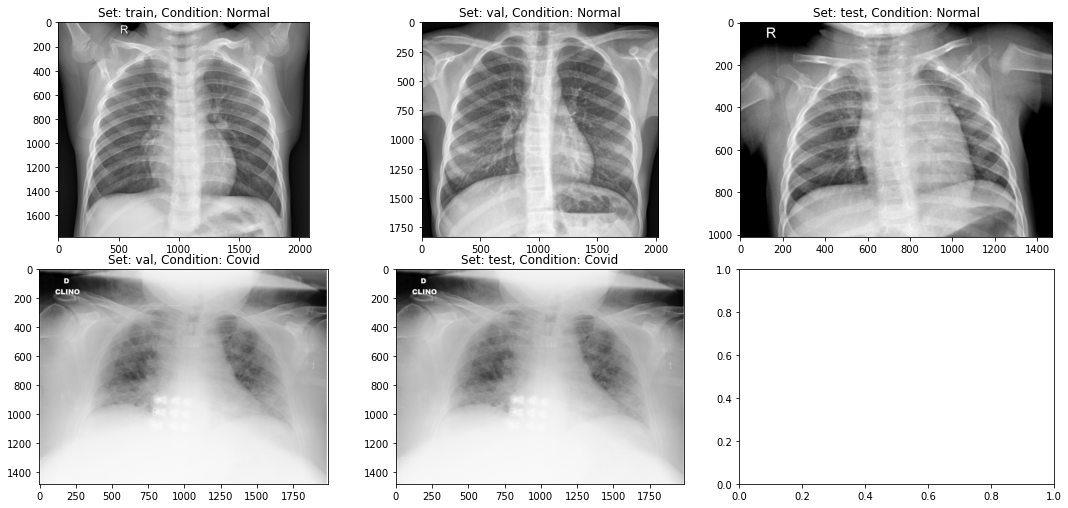

In [ ]:
input_path = '/content/drive/My Drive/COVID-19_Dataset/data/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))

    ax[i+2].imshow(plt.imread(set_path+'/COVID/'+os.listdir(set_path+'/COVID')[0]), cmap='gray')
    ax[i+2].set_title('Set: {}, Condition: Covid'.format(_set))

    #ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    #ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [ ]:
# Distribution of our datasets
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/COVID'))
    #n_pneum = len(os.listdir(input_path + _set +'/PNEUMONIA'))
    print('Set: {}, normal images: {}, Covid images'.format(_set, n_normal, n_infect)) #,n_pneum))

Set: train, normal images: 1259, Covid images
Set: val, normal images: 232, Covid images
Set: test, normal images: 1259, Covid images


In [ ]:
input_path = '/content/drive/My Drive/COVID-19_Dataset/data/'
img_dims=150
train_data=[]
train_labels=[]
for cond in ['/COVID/', '/NORMAL/']:
    for img in (os.listdir(input_path + 'train' + cond)):
        if cond=='/NORMAL/':
            label = 0
        elif cond=='/COVID/':
            label = 1
        #elif cond=='PNEUMONIA':
         #   label = 2
        img = cv2.imread(input_path+'train'+cond+img)
        #img = cv2.resize(img, (img_dims, img_dims))
        try:
           img = cv2.resize(img, (img_dims,img_dims), interpolation=cv2.INTER_AREA)
            #print(img.shape)
        except:
         break
        img = img.astype('float32') / 255
        
        train_data.append(np.array(img))      
        train_labels.append(np.array(label))

In [ ]:
test_data = []
test_labels = []

for cond in ['/NORMAL/', '/COVID/']:
    for img in (os.listdir(input_path + 'test' + cond)):
      if cond=='/NORMAL/':
          label = 0
      elif cond=='/COVID/':
          label = 1
     # elif cond=='/PNEUMONIA':
      #    label = 2
      img = cv2.imread(input_path+'test'+cond+img)
     # img = cv2.resize(img, (img_dims, img_dims))
      try:
           img = cv2.resize(img, (img_dims,img_dims), interpolation=cv2.INTER_AREA)
            #print(img.shape)
      except:
        break
        #img = np.dstack([img, img, img])
      img = img.astype('float32') / 255
        
      test_data.append(np.array(img))
      test_labels.append(np.array(label))
        
test_data = (np.array(test_data))
test_labels = (np.array(test_labels))
a=np.array(test_data)
a.shape

(1563, 150, 150, 3)

In [ ]:
a=np.array(test_data)
a1=np.array(test_labels)
b=np.array(train_data)
b1=np.array(train_labels)
print(b.shape)
print(a.shape)
print(a1.shape)
print(b1.shape)


(1563, 150, 150, 3)
(1563, 150, 150, 3)
(1563,)
(1563,)


In [ ]:
c=np.concatenate((a, b))
c_l=np.hstack((a1,b1))
c.shape

(3126, 150, 150, 3)

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image

In [ ]:
model = InceptionV3(weights='imagenet', include_top=False)
InceptionV3FeatureList = []

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
InceptionV3FeatureList = []
X = c
Y=np.array(c_l)
for i in range(X.shape[0]):
  I=X[i,:,:,:]
  I=np.expand_dims(I, axis=0)
  InceptionV3Feature = model.predict(I)
  InceptionV3FeatureNp = np.array(InceptionV3Feature)
  InceptionV3FeatureList.append(InceptionV3FeatureNp.flatten())

In [ ]:
XX = np.array(InceptionV3FeatureList)
print(XX.shape)
print(Y.shape)  


(3126, 18432)
(3126,)


In [ ]:
# SVM Classifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
x_train,x_test,y_train,y_test=train_test_split(XX,Y,random_state=42)
# the model
classifier_svc=SVC(kernel='rbf', C=1,random_state=42)
# fit the model using the training set
classifier_svc.fit(x_train,y_train)
#Accuracy score
accuracy=classifier_svc.score(x_test,y_test)
print(accuracy)


1.0


[[636   0]
 [  0 146]]

TEST METRICS ----------------------
Accuracy: 1.0%
Precision: 100.0%
Recall: 100.0%
F1-score: 100.0


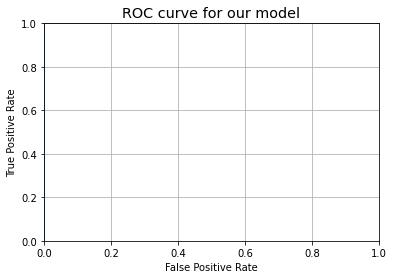

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
# predict the labels/classes of the test set
y_pred = classifier_svc.predict(x_test)
# build the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

tn, fp, fn, tp = cnf_matrix.ravel()
print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(accuracy))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)


Confusion Matrix without Normalization


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix with Normalized Values


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


([<matplotlib.axis.YTick at 0x7f54178ae250>,
 [Text(0, 0, 'Normal'), Text(0, 0, 'covid')])

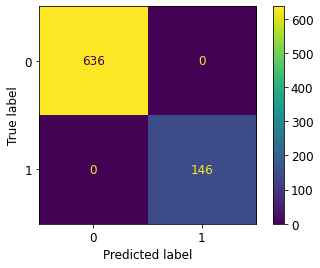

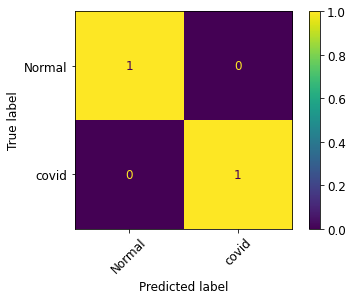

In [ ]:
#Plot Confusion Matrix
classes = ['Normal','covid']
print('Confusion Matrix without Normalization')
plot_confusion_matrix(classifier_svc, x_test, y_test,normalize=None)  
print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(classifier_svc, x_test, y_test,normalize='true')
tick_marks = [0,1]
plt.xticks(tick_marks, classes,rotation=45)
plt.yticks(tick_marks, classes)


Confusion Matrix without Normalization


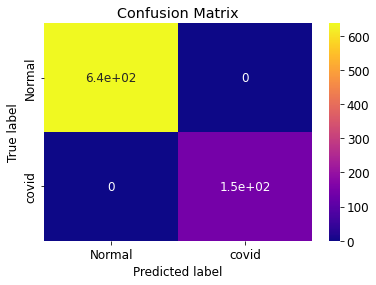

Confusion Matrix with Normalized Values


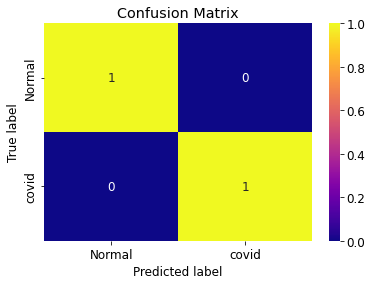

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['Normal','covid','Pneumonia']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test, y_pred,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')